In [ ]:
# This cell imports all necessary libraries and mounts Google Drive.

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from google.colab import drive

print("Setting up environment and mounting Google Drive...")
drive.mount('/content/drive')
print("Setup complete.")

Setting up environment and mounting Google Drive...
Mounted at /content/drive
Setup complete.


In [ ]:
# We load the 4 training CSVs, combine them, and immediately delete the
# original DataFrames to free up RAM.

DATA_PATH = '/content/drive/MyDrive/Wafer/'

print("\nLoading data...")

try:
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError

    # The first 2 files have a header, which we use to define the columns
    training_1 = pd.read_csv(f"{DATA_PATH}training_1.csv", delimiter=';', quotechar='"')
    training_4 = pd.read_csv(f"{DATA_PATH}training_4.csv", delimiter=';', quotechar='"')
    column_names = training_1.columns.tolist()

    # The other files do not have a header
    training_2 = pd.read_csv(f"{DATA_PATH}training_2.csv", sep=';', header=None, names=column_names, skiprows=1)
    training_3 = pd.read_csv(f"{DATA_PATH}training_3.csv", sep=';', header=None, names=column_names, skiprows=1)

    print("Combining datasets...")
    combined_data = pd.concat([training_1, training_2, training_3, training_4], ignore_index=True)

    # --- Memory Management ---
    print("Freeing up memory by deleting original dataframes...")
    del training_1, training_2, training_3, training_4
    gc.collect()

    print(f"Combined data loaded with shape: {combined_data.shape}")

except FileNotFoundError:
    print(f"FATAL ERROR: Could not find data files at '{DATA_PATH}'.")
    print("Please make sure the path is correct and that the files are present.")
    combined_data = None


Loading data...
Combining datasets...
Freeing up memory by deleting original dataframes...
Combined data loaded with shape: (14007200, 14)


In [ ]:
# Instead of trying to process the entire 14-million-row DataFrame at once,
# we process the data one wafer at a time.

def process_wafer_to_images(wafer_df, pattern_types, labels_map):
    """Pivots a single wafer's data into 2D image arrays, handling duplicates and reshaping."""
    wafer_maps = []
    labels = []

    # Ensure unique (x, y) pairs by grouping and aggregating before pivoting
    # Use mean for aggregation if there are multiple entries with same (x,y),
    try:
        # Group by x and y, then take the mean of other columns
        wafer_df_processed = wafer_df.groupby(['x', 'y'])[pattern_types].mean().reset_index()

        min_x, max_x = wafer_df_processed['x'].min(), wafer_df_processed['x'].max()
        min_y, max_y = wafer_df_processed['y'].min(), wafer_df_processed['y'].max()

        # Calculate the actual dimensions of the wafer data
        wafer_height = max_y - min_y + 1
        wafer_width = max_x - min_x + 1

        # Define the target canvas size
        canvas_height = 194
        canvas_width = 116

        for pattern in pattern_types:
            # Now pivot on the processed dataframe with unique (x, y) pairs
            wafer_map_2d = wafer_df_processed.pivot(index='y', columns='x', values=pattern).fillna(0)

            # Create a canvas based on the wafer map dimensions
            canvas = np.zeros((wafer_height, wafer_width))

            # Place the wafer map data onto the canvas, adjusting for min_x and min_y
            # This assumes the wafer_map_2d's index (y) and columns (x) are relative
            # to the wafer's min_y and min_x.
            # We need to map the pivoted data onto the canvas based on its actual coordinates.
            # Create a temporary canvas of the wafer's actual size
            temp_canvas = np.zeros((wafer_height, wafer_width))

            # Map the pivoted data to the temporary canvas
            # The pivoted DataFrame's index corresponds to y, columns to x
            # We need to shift these by min_y and min_x
            for row in wafer_df_processed.itertuples():
                relative_y = row.y - min_y
                relative_x = row.x - min_x
                for i, pattern_name in enumerate(pattern_types):
                     if pattern_name == pattern:
                          temp_canvas[relative_y, relative_x] = getattr(row, pattern_name)


            # Now pad the temporary canvas to the target canvas size (194x116)
            # Calculate padding amounts
            pad_height = canvas_height - wafer_height
            pad_width = canvas_width - wafer_width

            # Ensure padding is non-negative
            pad_top = max(0, pad_height // 2)
            pad_bottom = max(0, pad_height - pad_top)
            pad_left = max(0, pad_width // 2)
            pad_right = max(0, pad_width - pad_left)

            # Apply padding
            padded_canvas = np.pad(temp_canvas, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)

            # If the wafer is larger than the canvas, crop it
            if wafer_height > canvas_height or wafer_width > canvas_width:
                padded_canvas = padded_canvas[:canvas_height, :canvas_width]


            wafer_maps.append(padded_canvas)
            labels.append(labels_map[pattern])

    except Exception as e:
        print(f"Error processing wafer: {e}")
        # Return empty LISTS to avoid adding empty numpy arrays to the list
        return [], []


    return np.array(wafer_maps), np.array(labels)

In [ ]:
if combined_data is not None:
    print("\nCleaning and converting data types...")
    # Numeric columns are loaded as 'object' due to comma separators. We fix this.
    columns_to_convert = ['ring', 'spot', 'trend', 'twospots', 'crescent', 'ring_pure', 'spot_pure', 'trend_pure', 'twospots_pure', 'crescent_pure'] # Include pure columns for conversion
    for col in combined_data.columns: # Iterate through all columns to be safe
         if col in columns_to_convert and combined_data[col].dtype == 'object':
            combined_data[col] = combined_data[col].str.replace(',', '.').astype('float32') # Use float32 to save RAM


Cleaning and converting data types...


In [ ]:
if combined_data is not None:
    # Drop '_pure' columns as they are not needed for the analysis
    pure_columns = [col for col in combined_data.columns if '_pure' in col]
    combined_data = combined_data.drop(columns=pure_columns + ['lot'], errors='ignore') # Use errors='ignore' if 'lot' might be missing

In [ ]:
if combined_data is not None:
    # Process Wafer by Wafer
    all_wafer_maps = []
    all_labels = []

    pattern_types = ['ring', 'spot', 'trend', 'twospots', 'crescent'] # Including the optional 'trend'
    labels_map = {name: i for i, name in enumerate(pattern_types)}
    num_wafers = combined_data['wafer'].nunique()

    print(f"Starting to process {num_wafers} unique wafers")
    for i, (wafer_id, group) in enumerate(combined_data.groupby('wafer')):
        if (i + 1) % 50 == 0:
            print(f"  Processed {i+1}/{num_wafers} wafers...")
            gc.collect() # garbage collection periodically to save up the ram


        w_maps, w_labels = process_wafer_to_images(group, pattern_types, labels_map)
        if w_maps.size > 0: # Check if w_maps is not an empty numpy array
             all_wafer_maps.extend(w_maps)
             all_labels.extend(w_labels)
        else:
             print(f"Skipping wafer {wafer_id} due to processing error or empty result.")

        del w_maps, w_labels # delete temporary variables

Starting to process 800 unique wafers (this may take a few minutes)...
  Processed 50/800 wafers...
  Processed 100/800 wafers...
  Processed 150/800 wafers...
  Processed 200/800 wafers...
  Processed 250/800 wafers...
  Processed 300/800 wafers...
  Processed 350/800 wafers...
  Processed 400/800 wafers...
  Processed 450/800 wafers...
  Processed 500/800 wafers...
  Processed 550/800 wafers...
  Processed 600/800 wafers...
  Processed 650/800 wafers...
  Processed 700/800 wafers...
  Processed 750/800 wafers...
  Processed 800/800 wafers...


In [ ]:
if combined_data is not None:
    # Final Conversion and Cleanup
    print("\nConverting lists to final NumPy arrays...")
    # Ensure there's data before converting to numpy arrays
    if all_wafer_maps:
         wafer_maps = np.array(all_wafer_maps)
         labels = np.array(all_labels)

         print("\nData reshaped successfully.")
         print(f"Shape of wafer maps tensor: {wafer_maps.shape}")
         print(f"Shape of labels tensor: {labels.shape}")
    else:
         print("\nNo wafer maps were successfully processed.")
         wafer_maps = np.array([])
         labels = np.array([])


    print("Clearing large DataFrame from memory...")
    del combined_data
    if 'all_wafer_maps' in locals(): del all_wafer_maps
    if 'all_labels' in locals(): del all_labels
    gc.collect()


Converting lists to final NumPy arrays...

Data reshaped successfully.
Shape of wafer maps tensor: (4000, 194, 116)
Shape of labels tensor: (4000,)
Clearing large DataFrame from memory...


In [ ]:
# Create PyTorch Datasets and DataLoaders

# The data is now prepared for PyTorch. We add a 'channel' dimension for the
# CNN, convert arrays to Tensors, split into training (80%) and validation
# (20%) sets, and create DataLoaders to feed data to the model in batches.

if 'wafer_maps' in locals():
    wafer_maps = np.expand_dims(wafer_maps, axis=1)
    print(f"\nShape of wafer maps after adding channel dimension: {wafer_maps.shape}")

    # Convert data to PyTorch tensors
    X_tensor = torch.tensor(wafer_maps, dtype=torch.float32)
    y_tensor = torch.tensor(labels, dtype=torch.long)

    # Free up numpy array memory
    del wafer_maps, labels
    gc.collect()

    # Create a full dataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Split into training and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    print(f"\nTraining set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")

    # Create DataLoaders
    BATCH_SIZE = 64
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("PyTorch DataLoaders created successfully.")




Shape of wafer maps after adding channel dimension: (4000, 1, 194, 116)

Training set size: 3200
Validation set size: 800
PyTorch DataLoaders created successfully.


In [ ]:
# Add a 'channel' dimension for the CNN
if 'wafer_maps' in locals():
    wafer_maps = np.expand_dims(wafer_maps, axis=1)
    print(f"\nShape of wafer maps after adding channel dimension: {wafer_maps.shape}")

In [ ]:
# Convert data to PyTorch tensors
if 'wafer_maps' in locals() and 'labels' in locals():
    X_tensor = torch.tensor(wafer_maps, dtype=torch.float32)
    y_tensor = torch.tensor(labels, dtype=torch.long)

    # Free up numpy array memory
    del wafer_maps, labels
    gc.collect()

In [ ]:
# Create a full dataset
if 'X_tensor' in locals() and 'y_tensor' in locals():
    dataset = TensorDataset(X_tensor, y_tensor)

In [ ]:
# Split into training and validation sets
if 'dataset' in locals():
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    print(f"\nTraining set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")


Training set size: 3200
Validation set size: 800


In [ ]:
# Create DataLoaders
if 'train_dataset' in locals() and 'val_dataset' in locals():
    BATCH_SIZE = 64
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("PyTorch DataLoaders created successfully.")

PyTorch DataLoaders created successfully.


In [ ]:
# Define the CNN Model
# define a PyTorch Deep Learning mode. The architecture has two
# convolutional layers for feature extraction and a final linear
# layer for classification.

if 'train_loader' in locals():
    class WaferCNN(nn.Module):
        def __init__(self, num_classes=5, dropout_rate=0.5):
            super(WaferCNN, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(8),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(p=dropout_rate))


            self.layer2 = nn.Sequential(
                nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(p=dropout_rate))


            # Input size to FC layer is calculated from the output of the conv layers:
            # Initial: 194x116 -> Pool1: 97x58 -> Pool2: 48x29
            # Reduced filters: 48 * 29 * 16
            self.fc = nn.Linear(48 * 29 * 16, num_classes) # Adjusted input size to FC

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = out.reshape(out.size(0), -1) # Flatten the feature maps
            out = self.fc(out)
            return out

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}")

    model = WaferCNN(num_classes=len(pattern_types)).to(device)
    print("\nModel Architecture:")
    print(model)


Using device: cpu

Model Architecture:
WaferCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=22272, out_features=5, bias=True)
)


In [ ]:
# Define Loss Function and Optimizer

if 'model' in locals():
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    print("Loss function and optimizer defined.")

Loss function and optimizer defined.


In [ ]:
# Initialize variables for training

if 'model' in locals() and 'train_loader' in locals() and 'val_loader' in locals():
    NUM_EPOCHS = 5
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    print("\nTraining variables initialized.")


Training variables initialized.


In [ ]:
# Training Loop

if 'model' in locals() and 'train_loader' in locals() and 'val_loader' in locals():
    print("\nStarting model training...")
    for epoch in range(NUM_EPOCHS):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()


        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)


        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()


        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_accuracy = 100 * correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)


        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")


    print("Finished Training")

else:
    print("\nModel, train_loader, or val_loader not available. Please ensure previous steps were executed.")


Starting model training...
Epoch [1/5], Train Loss: 0.9348, Train Acc: 57.44%, Val Loss: 0.8082, Val Acc: 70.50%
Epoch [2/5], Train Loss: 0.5393, Train Acc: 75.34%, Val Loss: 0.7005, Val Acc: 61.88%
Epoch [3/5], Train Loss: 0.3205, Train Acc: 91.16%, Val Loss: 0.2830, Val Acc: 100.00%
Epoch [4/5], Train Loss: 0.2105, Train Acc: 94.34%, Val Loss: 0.2815, Val Acc: 98.38%
Epoch [5/5], Train Loss: 0.1317, Train Acc: 97.31%, Val Loss: 0.0879, Val Acc: 100.00%
Finished Training


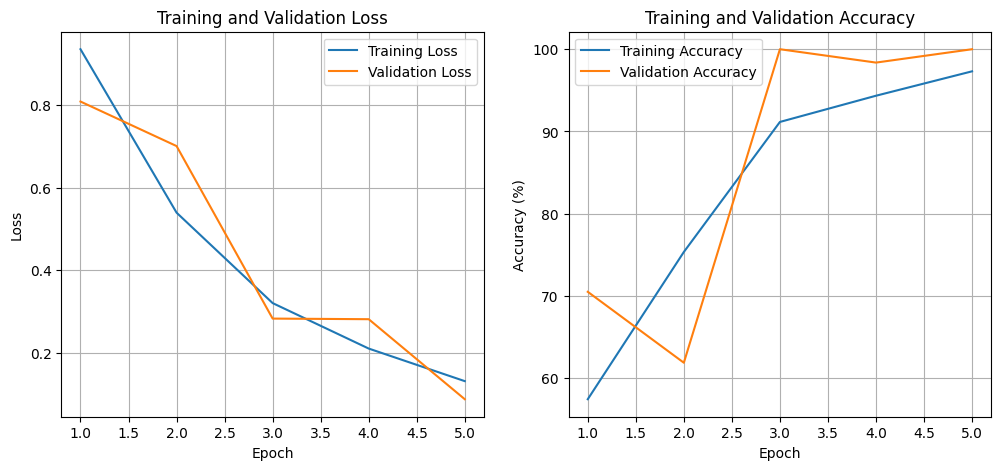

In [ ]:
# Plot learning curves

if 'train_losses' in locals() and 'val_losses' in locals() and 'train_accuracies' in locals() and 'val_accuracies' in locals() and 'NUM_EPOCHS' in locals():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
    plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()
else:
    print("\nLearning curve data not available. Please ensure the training loop was executed.")


--- Model Evaluation ---

F1 Score (Macro): 1.0000

Classification Report:
              precision    recall  f1-score   support

        ring       1.00      1.00      1.00       180
        spot       1.00      1.00      1.00       162
       trend       1.00      1.00      1.00       150
    twospots       1.00      1.00      1.00       151
    crescent       1.00      1.00      1.00       157

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800


Confusion Matrix:


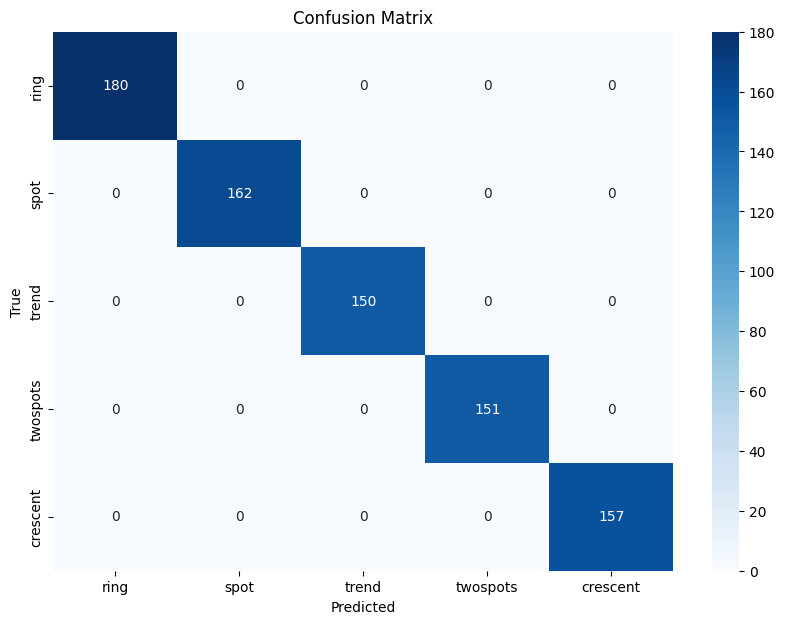

In [ ]:
# evaluate the final model's performance on the validation set and calculate
# the F1 score and also generate a classification report and a #confusion matrix

if 'model' in locals():
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            # We don't need to move labels to device here, just for comparison
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\n--- Model Evaluation ---")
    # F1 Score (as required)
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"\nF1 Score (Macro): {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=pattern_types))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pattern_types, yticklabels=pattern_types)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



In [ ]:
# save the trained weights and provide a function to simulate the
# required inference script. This function can load the saved model and make
# predictions on new data

if 'model' in locals():
    # Save the trained model's state dictionary
    MODEL_PATH = 'wafer_classification_model.pth'
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"\nModel saved to {MODEL_PATH}")

    def perform_inference(input_data_loader, model_path, device, num_classes):

        inference_model = WaferCNN(num_classes=num_classes).to(device)
        inference_model.load_state_dict(torch.load(model_path))
        inference_model.eval()

        predictions = []
        with torch.no_grad():
            # For inference, the dataloader would not have labels
            for images, _ in input_data_loader:
                images = images.to(device)
                outputs = inference_model(images)
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
        return predictions

    # Example of using the inference function on our validation data
    predicted_labels = perform_inference(val_loader, MODEL_PATH, device, num_classes=len(pattern_types))

    reverse_labels_map = {i: name for name, i in labels_map.items()}
    predicted_class_names = [reverse_labels_map[p] for p in predicted_labels]

    print("\nSample of 15 predictions from the inference function:")
    print(predicted_class_names[:15])


Model saved to wafer_classification_model.pth

Sample of 15 predictions from the inference function:
['spot', 'spot', 'ring', 'spot', 'trend', 'twospots', 'spot', 'spot', 'spot', 'spot', 'ring', 'ring', 'spot', 'twospots', 'crescent']


In [ ]:
# Load Test Data

print("[TESTING] Loading test data from 'test.csv'...")
try:
    test_df = pd.read_csv(f"{DATA_PATH}test.csv", delimiter=';', quotechar='"')
    print(f"[TESTING] Test data loaded with shape: {test_df.shape}")

    # Display the head of the test data
    print("\n[TESTING] Sample of Raw Test Data:")
    display(test_df.head())

except FileNotFoundError:
    print("FATAL ERROR: 'test.csv' not found. Skipping testing phase.")
    test_df = None

[TESTING] Loading test data from 'test.csv'...
[TESTING] Test data loaded with shape: (3501800, 14)

[TESTING] Sample of Raw Test Data:


,lot,wafer,x,y,ring,spot,trend,twospots,crescent,ring_pure,spot_pure,trend_pure,twospots_pure,crescent_pure
0,Lot_5,801,1,67,"0,0815646268616209","0,000212543869360751","0,507566413742191","0,0205134400709553","-0,000525905406861593","0,0781820391290924","2,03923375035647e-14","0,511632066832587","0,0206508244731195","-4,84314598172959e-17"
1,Lot_5,801,1,68,"0,0804068600774856","2,88716473880083e-05","0,528583809149706","0,0210471241841105","-0,0108790503669245","0,0785869843991606","3,80980481681389e-14","0,511632066832587","0,0211663791263623","-5,07606418493978e-17"
2,Lot_5,801,1,69,"0,0832909076226504","4,31485239380615e-05","0,498000133093142","0,0211853885594444","0,00589031168010191","0,0789058795055616","7,04684670832181e-14","0,511632066832587","0,0216543026053096","-5,29028513056874e-17"
3,Lot_5,801,1,70,"0,0811184587796342","-5,22432661390929e-05","0,532267673082906","0,0228424288133956","-0,00120256758168395","0,0791526100005659","1,29045611354418e-13","0,511632066832587","0,0221140315856408","-5,56129609519792e-17"
4,Lot_5,801,1,71,"0,0803892533800839","0,000300180920221645","0,544995893302162","0,0224363081417157","-0,00833773056013449","0,0793398638677927","2,33963814845839e-13","0,511632066832587","0,0225452766877449","-5,76665485366261e-17"


In [ ]:
# Clean and Convert Test Data Types

if 'test_df' in locals() and test_df is not None:
    print("\n[TESTING] Cleaning and converting data types for test data...")
    columns_to_convert = ['ring', 'spot', 'trend', 'twospots', 'crescent', 'ring_pure', 'spot_pure', 'trend_pure', 'twospots_pure', 'crescent_pure'] # Include pure columns for conversion
    for col in columns_to_convert:
        if col in test_df.columns and test_df[col].dtype == 'object':
            test_df[col] = test_df[col].str.replace(',', '.').astype('float32') # Use float32 to save RAM

    # Drop '_pure' columns as they are not needed for the analysis
    pure_columns = [col for col in test_df.columns if '_pure' in col]
    test_df = test_df.drop(columns=pure_columns + ['lot'], errors='ignore') # Use errors='ignore' if 'lot' might be missing


[TESTING] Cleaning and converting data types for test data...


In [ ]:
# Process Test Data Wafer by Wafer

if 'test_df' in locals() and test_df is not None:
    # --- Diagnostic: Check for duplicates before processing ---
    print("\n[TESTING] Checking for duplicate (x, y) pairs in test data per wafer...")
    duplicate_check = test_df.groupby('wafer').apply(lambda x: x.duplicated(subset=['x', 'y']).any())
    wafers_with_duplicates = duplicate_check[duplicate_check].index.tolist()

    if wafers_with_duplicates:
        print(f"[TESTING] Found duplicate (x, y) pairs in wafers: {wafers_with_duplicates[:10]}...") # Print first 10 if many
        print("[TESTING] These duplicates will be handled by process_wafer_to_images.")
    else:
        print("[TESTING] No duplicate (x, y) pairs found in test data.")

    # --- Diagnostic: Check the number of unique wafers in the test set ---
    num_test_wafers = test_df['wafer'].nunique()
    print(f"[TESTING] Number of unique wafers in test data: {num_test_wafers}")


    # Process the test dataframe into images and ground truth labels wafer by wafer
    all_test_wafer_maps = []
    all_test_labels = []

    # Assuming pattern_types and labels_map are defined in a previous cell
    # pattern_types = ['ring', 'spot', 'trend', 'twospots', 'crescent']
    # labels_map = {name: i for i, name in enumerate(pattern_types)}

    print(f"[TESTING] Starting to process {num_test_wafers} unique test wafers...")
    for i, (wafer_id, group) in enumerate(test_df.groupby('wafer')):
        if (i + 1) % 50 == 0:
            print(f"[TESTING]   Processed {i+1}/{num_test_wafers} test wafers...")
            gc.collect() # Explicit garbage collection periodically

        w_maps, w_labels = process_wafer_to_images(group, pattern_types, labels_map)
        if w_maps.size > 0:
            all_test_wafer_maps.extend(w_maps)
            all_test_labels.extend(w_labels)
        else:
             print(f"[TESTING] Skipping test wafer {wafer_id} due to processing error or empty result.")

        del w_maps, w_labels # Explicitly delete temporary variables


[TESTING] Checking for duplicate (x, y) pairs in test data per wafer...
[TESTING] No duplicate (x, y) pairs found in test data.
[TESTING] Number of unique wafers in test data: 200
[TESTING] Starting to process 200 unique test wafers...
[TESTING]   Processed 50/200 test wafers...
[TESTING]   Processed 100/200 test wafers...
[TESTING]   Processed 150/200 test wafers...
[TESTING]   Processed 200/200 test wafers...


In [ ]:
# Final Conversion and Cleanup for Test Data

if 'all_test_wafer_maps' in locals():
    if all_test_wafer_maps:
         test_images = np.array(all_test_wafer_maps)
         test_labels_true = np.array(all_test_labels)

         print(f"\n[TESTING] Test data reshaped successfully.")
         print(f"[TESTING] Shape of test wafer maps tensor: {test_images.shape}")
         print(f"[TESTING] Shape of test labels tensor: {test_labels_true.shape}")
    else:
         print("\n[TESTING] No test wafer maps were successfully processed.")
         test_images = np.array([])
         test_labels_true = np.array([])


    print("[TESTING] Clearing large test DataFrame from memory...")
    if 'test_df' in locals(): del test_df
    if 'all_test_wafer_maps' in locals(): del all_test_wafer_maps
    if 'all_test_labels' in locals(): del all_test_labels
    gc.collect()


[TESTING] Test data reshaped successfully.
[TESTING] Shape of test wafer maps tensor: (1000, 194, 116)
[TESTING] Shape of test labels tensor: (1000,)
[TESTING] Clearing large test DataFrame from memory...


In [ ]:
# Prepare Test Data for Inference

if 'test_images' in locals():
    # Add channel dimension
    test_images = np.expand_dims(test_images, axis=1)
    print(f"\n[TESTING] Shape of test wafer maps after adding channel dimension: {test_images.shape}")

    # Convert to PyTorch tensor
    X_test_tensor = torch.tensor(test_images, dtype=torch.float32)
    y_test_tensor = torch.tensor(test_labels_true, dtype=torch.long) # Keep ground truth for evaluation

    # Create a test dataset and dataloader
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("\n[TESTING] PyTorch Test DataLoader created successfully.")

    # Free up numpy array memory
    del test_images, test_labels_true
    gc.collect()


[TESTING] Shape of test wafer maps after adding channel dimension: (1000, 1, 194, 116)

[TESTING] PyTorch Test DataLoader created successfully.



[TESTING] Performing inference on test data...

--- [TESTING] Model Evaluation on Test Data ---

[TESTING] F1 Score (Macro) on Test Data: 1.0000

[TESTING] Classification Report on Test Data:
              precision    recall  f1-score   support

        ring       1.00      1.00      1.00       200
        spot       1.00      1.00      1.00       200
       trend       1.00      1.00      1.00       200
    twospots       1.00      1.00      1.00       200
    crescent       1.00      1.00      1.00       200

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


[TESTING] Confusion Matrix on Test Data:


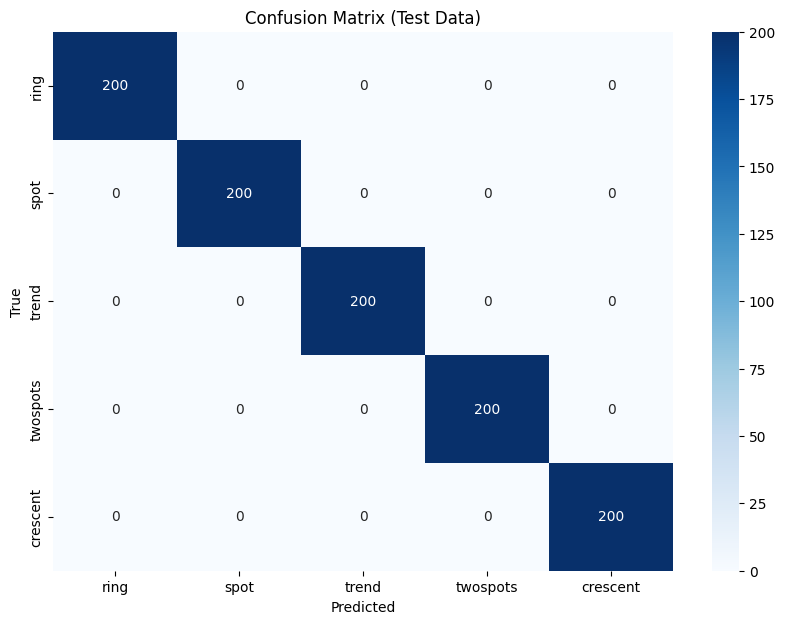

In [ ]:
# Perform Inference and Evaluate on Test Data

if 'test_loader' in locals() and 'MODEL_PATH' in locals() and 'device' in locals() and 'pattern_types' in locals() and 'labels_map' in locals():
    print("\n[TESTING] Performing inference on test data...")
    predicted_labels_test = perform_inference(test_loader, MODEL_PATH, device, num_classes=len(pattern_types))

    # Evaluate performance on test set
    print("\n--- [TESTING] Model Evaluation on Test Data ---")
    # F1 Score (as required)
    f1_test = f1_score(test_dataset.tensors[1].numpy(), predicted_labels_test, average='macro')
    print(f"\n[TESTING] F1 Score (Macro) on Test Data: {f1_test:.4f}")

    print("\n[TESTING] Classification Report on Test Data:")
    print(classification_report(test_dataset.tensors[1].numpy(), predicted_labels_test, target_names=pattern_types))

    print("\n[TESTING] Confusion Matrix on Test Data:")
    cm_test = confusion_matrix(test_dataset.tensors[1].numpy(), predicted_labels_test)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=pattern_types, yticklabels=pattern_types)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Data)')
    plt.show()

else:
    print("\n[TESTING] Test loader, model path, device, or pattern types not available. Skipping test inference and evaluation.")